# 6. Stochastic and Mini-Batch Gradient Descent

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (17/12/2022)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.5.1)
- Numpy (tested on v1.22.1)
- Time

### Imports

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
# Numpy
import numpy as np
from numpy.random import default_rng
# Time
from time import time
# Removing unecessary warnings (optional, just makes notebook outputs more readable)
import warnings
warnings.filterwarnings("ignore")

### Mock dataset, with nonlinearity

As in the previous notebook, we will reuse our nonlinear binary classification mock dataset and generate 1000 samples.

In [2]:
# All helper functions
eps = 1e-5
min_val = -1 + eps
max_val = 1 - eps
def val(min_val, max_val):
    return round(np.random.uniform(min_val, max_val), 2)
def class_for_val(val1, val2):
    k = np.pi
    return int(val2 >= -1/4 + 3/4*np.sin(val1*k))
n_points = 1000
def create_dataset(n_points, min_val, max_val):
    val1_list = np.array([val(min_val, max_val) for _ in range(n_points)])
    val2_list = np.array([val(min_val, max_val) for _ in range(n_points)])
    inputs = np.array([[v1, v2] for v1, v2 in zip(val1_list, val2_list)])
    outputs = np.array([class_for_val(v1, v2) for v1, v2 in zip(val1_list, val2_list)]).reshape(n_points, 1)
    return val1_list, val2_list, inputs, outputs

In [3]:
# Generate dataset
np.random.seed(47)
val1_list, val2_list, inputs, outputs = create_dataset(n_points, min_val, max_val)
# Check a few entries of the dataset
print(inputs.shape)
print(outputs.shape)

(1000, 2)
(1000, 1)


As expected and observed in the plots below, the dataset now longer exhibits linearity.

In fact, the function is no longer polynomial either due to the presence of a sine function.

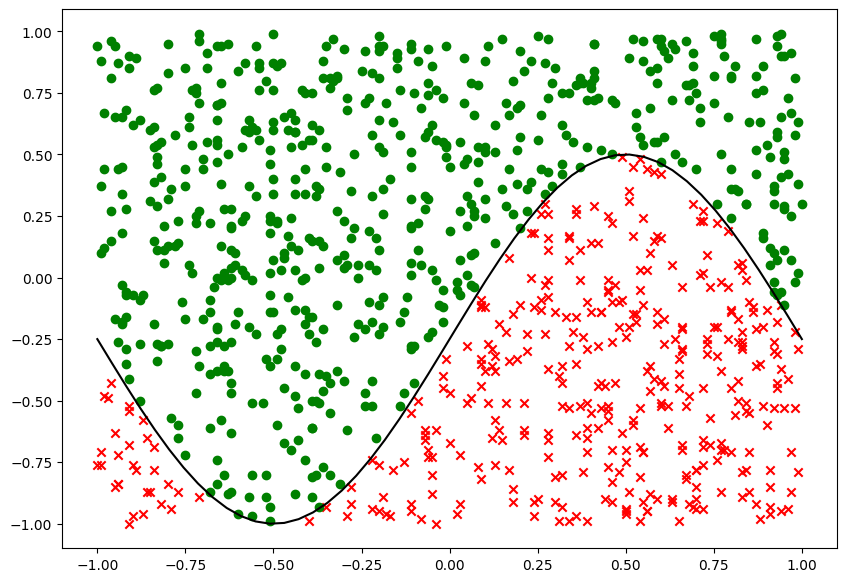

In [4]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# Scatter plot
markers = {0: "x", 1: "o"}
colors = {0: "r", 1: "g"}
indexes_0 = np.where(outputs == 0)[0]
v1_0 = val1_list[indexes_0]
v2_0 = val2_list[indexes_0]
indexes_1 = np.where(outputs == 1)[0]
v1_1 = val1_list[indexes_1]
v2_1 = val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])
    
# Display true boundary
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_true = [-1/4 + 3/4*np.sin(v1*np.pi) for v1 in x1]
plt.plot(x1, x2_true, "k", label = "True boundary")

# Show
plt.show()

### Shallow Neural Net, with Batch Gradient Descent 

Our implementation of the gradient descent, so far, is called **Batch Gradient Descent**.

Batch gradient descent is an optimization algorithm used to train machine learning models, particularly neural networks. It is a type of gradient descent, which is an iterative optimization algorithm that works by adjusting the model's weights and biases in the direction that minimizes the loss function.

In batch gradient descent, the algorithm uses the **entire dataset** to compute the gradients at each iteration. This means that the gradients are calculated using the average of the gradients of all the training examples in the dataset. The model's weights and biases are then updated using these gradients, and the process is repeated until the model converges to a good solution.

One of the main advantages of batch gradient descent is that it is relatively simple and easy to implement. It is also relatively fast and efficient, especially for small datasets, as the gradients are calculated only once per iteration. 

However, for very large datasets, batch gradient descent can be slow and computationally intensive, as it requires processing the entire dataset at each iteration. In these cases, it may be more efficient to use an optimization algorithm that processes the data in smaller batches, such as stochastic gradient descent or mini-batch gradient descent, which will be discussed later.

For now, let us reuse our previous Shallow Neural Network clas with Adam, and rename it **ShallowNeuralNet_Batch**.

In [5]:
class ShallowNeuralNet_Batch():
    
    def __init__(self, n_x, n_h, n_y):
        # Network dimensions
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        # Initialize parameters
        self.init_parameters_normal()
        # Loss, initialized as infinity before first calculation is made
        self.loss = float("Inf")
         
    def init_parameters_normal(self):
        # Weights and biases matrices (randomly initialized)
        self.W1 = np.random.randn(self.n_x, self.n_h)*0.1
        self.b1 = np.random.randn(1, self.n_h)*0.1
        self.W2 = np.random.randn(self.n_h, self.n_y)*0.1
        self.b2 = np.random.randn(1, self.n_y)*0.1

    def sigmoid(self, val):
        return 1/(1 + np.exp(-val))
    
    def forward(self, inputs):
        # Wx + b operation for the first layer
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        # Wx + b operation for the second layer
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        y_pred = self.sigmoid(Z2_b)
        return y_pred
    
    def CE_loss(self, inputs, outputs):
        # MSE loss function as before
        outputs_re = outputs.reshape(-1, 1)
        pred = self.forward(inputs)
        eps = 1e-10
        losses = outputs*np.log(pred + eps) + (1 - outputs)*np.log(1 - pred + eps)
        self.loss = -np.sum(losses)/outputs.shape[0]
        return self.loss
    
    def backward(self, inputs, outputs, G_list, iteration_number, alpha = 1e-5, beta1 = 0.9, beta2 = 0.999):
        # Get the number of samples in dataset
        m = inputs.shape[0]
        
        # Forward propagate
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        y_pred = self.sigmoid(Z2_b)
    
        # Compute error term
        epsilon = y_pred - outputs
        gradient_output = epsilon*y_pred*(1 - y_pred)
        error_hidden = np.dot(gradient_output, self.W2.T)
        gradient_hidden = error_hidden*A1*(1 - A1)
        
        # Compute gradients
        grad_W2 = -(1/m)*np.dot(A1.T, gradient_output)
        grad_W1 = -(1/m)*np.dot(inputs.T, gradient_hidden)
        grad_b2 = -(1/m)*np.sum(gradient_output, axis = 0, keepdims = True)
        grad_b1 = -(1/m)*np.sum(gradient_hidden, axis = 0, keepdims = True)
        
        # Momentum and gradient decay/normalization for each parameter
        V_W2, V_W1, V_b2, V_b1, S_W2, S_W1, S_b2, S_b1 = G_list
        V_W2 = beta1*V_W2 + (1 - beta1)*grad_W2
        V_W1 = beta1*V_W1 + (1 - beta1)*grad_W1
        V_b2 = beta1*V_b2 + (1 - beta1)*grad_b2
        V_b1 = beta1*V_b1 + (1 - beta1)*grad_b1
        V_W2_norm = V_W2/(1 - beta1**iteration_number)
        V_W1_norm = V_W1/(1 - beta1**iteration_number)
        V_b2_norm = V_b2/(1 - beta1**iteration_number)
        V_b1_norm = V_b1/(1 - beta1**iteration_number)
        S_W2 = beta2*S_W2 + (1 - beta2)*grad_W2**2
        S_W1 = beta2*S_W1 + (1 - beta2)*grad_W1**2
        S_b2 = beta2*S_b2 + (1 - beta2)*grad_b2**2
        S_b1 = beta2*S_b1 + (1 - beta2)*grad_b1**2
        S_W2_norm = S_W2/(1 - beta2**iteration_number)
        S_W1_norm = S_W1/(1 - beta2**iteration_number)
        S_b2_norm = S_b2/(1 - beta2**iteration_number)
        S_b1_norm = S_b1/(1 - beta2**iteration_number)
        G_list = [V_W2, V_W1, V_b2, V_b1, S_W2, S_W1, S_b2, S_b1]
        
        # Gradient descent update rules
        eps = 1e-6
        self.W2 += alpha*V_W2_norm/(np.sqrt(S_W2_norm) + eps)
        self.W1 += alpha*V_W1_norm/(np.sqrt(S_W1_norm) + eps)
        self.b2 += alpha*V_b2_norm/(np.sqrt(S_b2_norm) + eps)
        self.b1 += alpha*V_b1_norm/(np.sqrt(S_b1_norm) + eps)
        
        # Update loss
        self.CE_loss(inputs, outputs)
        return G_list
    
    def train(self, inputs, outputs, N_max = 1000, alpha = 1e-5, beta1 = 0.9, beta2 = 0.999, delta = 1e-5, display = True):
        # List of losses, starts with the current loss
        self.losses_list = [self.loss]
        # Initialize G_list
        G_list = [0*self.W2, 0*self.W1, 0*self.b2, 0*self.b1, \
                  0*self.W2, 0*self.W1, 0*self.b2, 0*self.b1]
        # Repeat iterations
        for iteration_number in range(1, N_max + 1):
            # Backpropagate
            G_list = self.backward(inputs, outputs, G_list, iteration_number, alpha, beta1, beta2)
            new_loss = self.loss
            # Update losses list
            self.losses_list.append(new_loss)
            # Display
            if(display and iteration_number % (N_max*0.05) == 1):
                print("Iteration {} - Loss = {}".format(iteration_number, new_loss))
            # Check for delta value and early stop criterion
            difference = abs(self.losses_list[-1] - self.losses_list[-2])
            if(difference < delta):
                if(display):
                    print("Stopping early - loss evolution was less than delta on iteration {}.".format(iteration_number))
                break
        else:
            # Else on for loop will execute if break did not trigger
            if(display):
                print("Stopping - Maximal number of iterations reached.")
    
    def show_losses_over_training(self):
        # Initialize matplotlib
        fig, axs = plt.subplots(1, 2, figsize = (15, 5))
        axs[0].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[0].set_xlabel("Iteration number")
        axs[0].set_ylabel("Loss")
        axs[1].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[1].set_xlabel("Iteration number")
        axs[1].set_ylabel("Loss (in logarithmic scale)")
        axs[1].set_yscale("log")
        # Display
        plt.show()

As expected, it trains correctly.

We also time it for later.

In [6]:
# Define and train neural network structure (batch GD)
n_x = 2
n_h = 10
n_y = 1
np.random.seed(37)
shallow_neural_net_batch = ShallowNeuralNet_Batch(n_x, n_h, n_y)
# Train and show final loss (time it also)
start = time()
shallow_neural_net_batch.train(inputs, outputs, N_max = 10000, alpha = 1e-1, beta1 = 0.9, \
                               beta2 = 0.999, delta = 1e-10, display = True)
end = time()
time_batch = end - start
print(shallow_neural_net_batch.loss)

Iteration 1 - Loss = 0.6561840401736492
Iteration 501 - Loss = 0.028117073418567944
Iteration 1001 - Loss = 0.014523173680372137
Iteration 1501 - Loss = 0.009527375327813161
Iteration 2001 - Loss = 0.006761285435984955
Iteration 2501 - Loss = 0.005001566583284715
Iteration 3001 - Loss = 0.003804680874974412
Iteration 3501 - Loss = 0.002954976773890774
Iteration 4001 - Loss = 0.0023425205345427545
Iteration 4501 - Loss = 0.0018888156622302405
Iteration 5001 - Loss = 0.0015436794381827274
Iteration 5501 - Loss = 0.0012745069060635852
Iteration 6001 - Loss = 0.001061612605660608
Iteration 6501 - Loss = 0.0008912301199444346
Iteration 7001 - Loss = 0.0007534056470510379
Iteration 7501 - Loss = 0.0006408751537735276
Iteration 8001 - Loss = 0.0005482682344243042
Iteration 8501 - Loss = 0.0004715524203546768
Iteration 9001 - Loss = 0.00040764996855182967
Iteration 9501 - Loss = 0.0003541743343329034
Stopping - Maximal number of iterations reached.
0.00030933051954046037


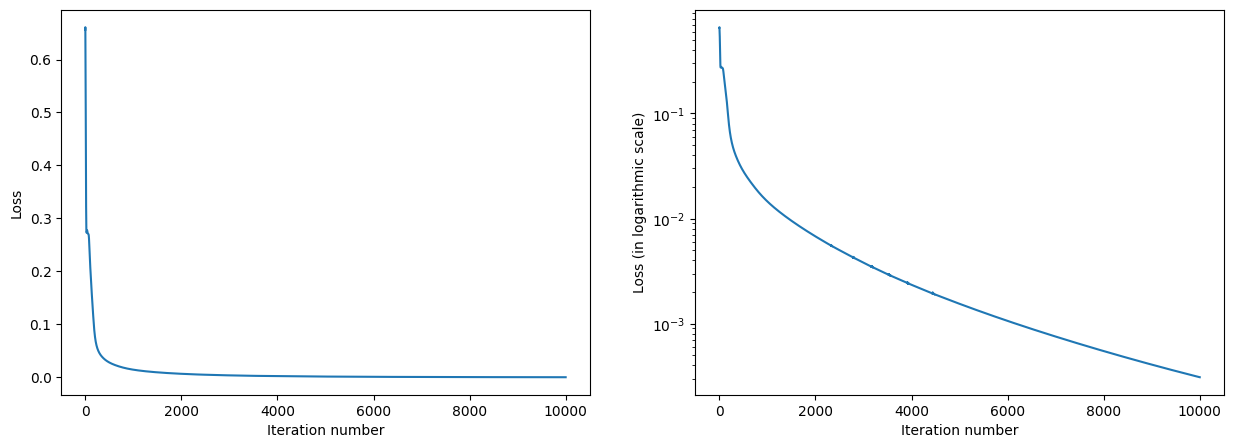

In [7]:
shallow_neural_net_batch.show_losses_over_training()

### Shallow Neural Net, with Stochastic Gradient Descent 

Stochastic gradient descent (SGD) is an optimization algorithm used to train machine learning models, particularly neural networks. It is a variant of gradient descent, which is an iterative optimization algorithm that works by adjusting the model's weights and biases in the direction that minimizes the loss function.

In stochastic gradient descent, the algorithm uses a **single training sample** to compute the gradients at each iteration.

This means that the gradients are calculated using the gradients of a single training example, rather than the average of the gradients of all the training examples in the dataset as in batch gradient descent. The model's weights and biases are then updated using these gradients.

The process is then repeated for each training example in the dataset (or it may only use one or a subset of the dataset on each iteration until the model converges to a good solution.

One of the main advantages of stochastic gradient descent is that it can be much faster and more efficient than batch gradient descent for very large datasets, as it processes the data in small, independent chunks. It can also be more resistant to getting stuck in local minima or saddle points, as it is constantly making small adjustments to the model's weights and biases based on the gradients of individual training examples.

However, the stochastic nature of the algorithm can also make it more prone to noise and oscillation, and it may require more fine-tuning of the learning rate and other hyperparameters to achieve good results.

We implement it below in the **ShallowNeuralNet_Stochastic** class, whose **train()** method now include a procedure for drawing a single random sample on each iteration, and then uses this sample in the **backward()** method. More specifically, pay attention to the lines:

```
# Stochastic GD on one randomly chosen sample
indexes = np.random.randint(0, M)
inputs_sub = np.array([inputs[indexes, :]])
outputs_sub = np.array([outputs[indexes, :]])

# Backpropagate
G_list, loss = self.backward(inputs_sub, outputs_sub, G_list, iteration_number, alpha, beta1, beta2)

```

In [8]:
class ShallowNeuralNet_Stochastic():
    
    def __init__(self, n_x, n_h, n_y):
        # Network dimensions
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        # Initialize parameters
        self.init_parameters_normal()
        # Loss, initialized as infinity before first calculation is made
        self.loss = float("Inf")
         
    def init_parameters_normal(self):
        # Weights and biases matrices (randomly initialized)
        self.W1 = np.random.randn(self.n_x, self.n_h)*0.1
        self.b1 = np.random.randn(1, self.n_h)*0.1
        self.W2 = np.random.randn(self.n_h, self.n_y)*0.1
        self.b2 = np.random.randn(1, self.n_y)*0.1

    def sigmoid(self, val):
        return 1/(1 + np.exp(-val))
    
    def forward(self, inputs):
        # Wx + b operation for the first layer
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        # Wx + b operation for the second layer
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        y_pred = self.sigmoid(Z2_b)
        return y_pred
    
    def CE_loss(self, inputs, outputs):
        # MSE loss function as before
        outputs_re = outputs.reshape(-1, 1)
        pred = self.forward(inputs)
        eps = 1e-10
        losses = outputs*np.log(pred + eps) + (1 - outputs)*np.log(1 - pred + eps)
        loss = -np.sum(losses)/outputs.shape[0]
        return loss
    
    def backward(self, inputs, outputs, G_list, iteration_number, alpha = 1e-5, beta1 = 0.9, beta2 = 0.999):
        # Get the number of samples in dataset
        m = inputs.shape[0]
        
        # Forward propagate
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        y_pred = self.sigmoid(Z2_b)
    
        # Compute error term
        epsilon = y_pred - outputs
        gradient_output = epsilon*y_pred*(1 - y_pred)
        error_hidden = np.dot(gradient_output, self.W2.T)
        gradient_hidden = error_hidden*A1*(1 - A1)
        
        # Compute gradients
        grad_W2 = -(1/m)*np.dot(A1.T, gradient_output)
        grad_W1 = -(1/m)*np.dot(inputs.T, gradient_hidden)
        grad_b2 = -(1/m)*np.sum(gradient_output, axis = 0, keepdims = True)
        grad_b1 = -(1/m)*np.sum(gradient_hidden, axis = 0, keepdims = True)
        
        # Momentum and gradient decay/normalization for each parameter
        V_W2, V_W1, V_b2, V_b1, S_W2, S_W1, S_b2, S_b1 = G_list
        V_W2 = beta1*V_W2 + (1 - beta1)*grad_W2
        V_W1 = beta1*V_W1 + (1 - beta1)*grad_W1
        V_b2 = beta1*V_b2 + (1 - beta1)*grad_b2
        V_b1 = beta1*V_b1 + (1 - beta1)*grad_b1
        V_W2_norm = V_W2/(1 - beta1**iteration_number)
        V_W1_norm = V_W1/(1 - beta1**iteration_number)
        V_b2_norm = V_b2/(1 - beta1**iteration_number)
        V_b1_norm = V_b1/(1 - beta1**iteration_number)
        S_W2 = beta2*S_W2 + (1 - beta2)*grad_W2**2
        S_W1 = beta2*S_W1 + (1 - beta2)*grad_W1**2
        S_b2 = beta2*S_b2 + (1 - beta2)*grad_b2**2
        S_b1 = beta2*S_b1 + (1 - beta2)*grad_b1**2
        S_W2_norm = S_W2/(1 - beta2**iteration_number)
        S_W1_norm = S_W1/(1 - beta2**iteration_number)
        S_b2_norm = S_b2/(1 - beta2**iteration_number)
        S_b1_norm = S_b1/(1 - beta2**iteration_number)
        G_list = [V_W2, V_W1, V_b2, V_b1, S_W2, S_W1, S_b2, S_b1]
        
        # Gradient descent update rules
        eps = 1e-6
        self.W2 += alpha*V_W2_norm/(np.sqrt(S_W2_norm) + eps)
        self.W1 += alpha*V_W1_norm/(np.sqrt(S_W1_norm) + eps)
        self.b2 += alpha*V_b2_norm/(np.sqrt(S_b2_norm) + eps)
        self.b1 += alpha*V_b1_norm/(np.sqrt(S_b1_norm) + eps)
        
        # Update loss
        loss = self.CE_loss(inputs, outputs)
        return G_list, loss
    
    def train(self, inputs, outputs, N_max = 1000, alpha = 1e-5, beta1 = 0.9, beta2 = 0.999, delta = 1e-5, display = True):
        # Get number of samples
        M = inputs.shape[0]
        # List of losses, starts with the current loss
        self.losses_list = [self.CE_loss(inputs, outputs)]
        # Initialize G_list
        G_list = [0*self.W2, 0*self.W1, 0*self.b2, 0*self.b1, \
                  0*self.W2, 0*self.W1, 0*self.b2, 0*self.b1]
        # Repeat iterations
        for iteration_number in range(1, N_max + 1):
            # Stochastic GD on one randomly chosen sample
            indexes = np.random.randint(0, M)
            inputs_sub = np.array([inputs[indexes, :]])
            outputs_sub = np.array([outputs[indexes, :]])

            # Backpropagate
            G_list, loss = self.backward(inputs_sub, outputs_sub, G_list, iteration_number, alpha, beta1, beta2)
                
            # Update loss attribute on all losses
            self.loss = self.CE_loss(inputs, outputs)
            
            # Update losses list
            self.losses_list.append(self.loss)
            
            # Display
            if(display and iteration_number % (N_max*0.05) == 1):
                print("Iteration {} - Loss = {}".format(iteration_number, self.loss))
            # Check for delta value and early stop criterion
            difference = abs(self.losses_list[-1] - self.losses_list[-2])
            if(difference < delta):
                if(display):
                    message = "Stopping early - loss evolution was less than delta on"
                    message += "iteration {}.".format(iteration_number)
                    print(message)
                    break
        else:
            # Else on for loop will execute if break did not trigger
            if(display):
                print("Stopping - Maximal number of iterations reached.")

    def show_losses_over_training(self):
        # Initialize matplotlib
        fig, axs = plt.subplots(1, 2, figsize = (15, 5))
        axs[0].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[0].set_xlabel("Iteration number")
        axs[0].set_ylabel("Loss")
        axs[1].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[1].set_xlabel("Iteration number")
        axs[1].set_ylabel("Loss (in logarithmic scale)")
        axs[1].set_yscale("log")
        # Display
        plt.show()

As expected, the model is able to train, but "oscillates" a bit when approaching convergence.

We also time it for later.

In [9]:
# Define and train neural network structure (Stochastic GD)
n_x = 2
n_h = 10
n_y = 1
np.random.seed(37)
shallow_neural_net_sto = ShallowNeuralNet_Stochastic(n_x, n_h, n_y)
# Train and show final loss (and time it)
start = time()
shallow_neural_net_sto.train(inputs, outputs, N_max = 10000, alpha = 1e-2, beta1 = 0.9, \
                               beta2 = 0.999, delta = 1e-10, display = True)
end = time()
time_sto = end - start
print(shallow_neural_net_sto.loss)

Iteration 1 - Loss = 0.6922499969324454
Iteration 501 - Loss = 0.3188848371213821
Iteration 1001 - Loss = 0.306644968613527
Iteration 1501 - Loss = 0.28210537179242534
Iteration 2001 - Loss = 0.28459821840120514
Iteration 2501 - Loss = 0.27476480917682455
Iteration 3001 - Loss = 0.2782089714330207
Iteration 3501 - Loss = 0.28115412489048514
Iteration 4001 - Loss = 0.27803036620013566
Iteration 4501 - Loss = 0.26555610970377164
Iteration 5001 - Loss = 0.2582368009814412
Iteration 5501 - Loss = 0.24835833410781763
Iteration 6001 - Loss = 0.23462509922336527
Iteration 6501 - Loss = 0.24747599328579434
Iteration 7001 - Loss = 0.22326583888490567
Iteration 7501 - Loss = 0.213529711307548
Iteration 8001 - Loss = 0.21405084948033393
Iteration 8501 - Loss = 0.20649618568274947
Iteration 9001 - Loss = 0.20222190385916183
Iteration 9501 - Loss = 0.1946564870614685
Stopping - Maximal number of iterations reached.
0.19441398474206067


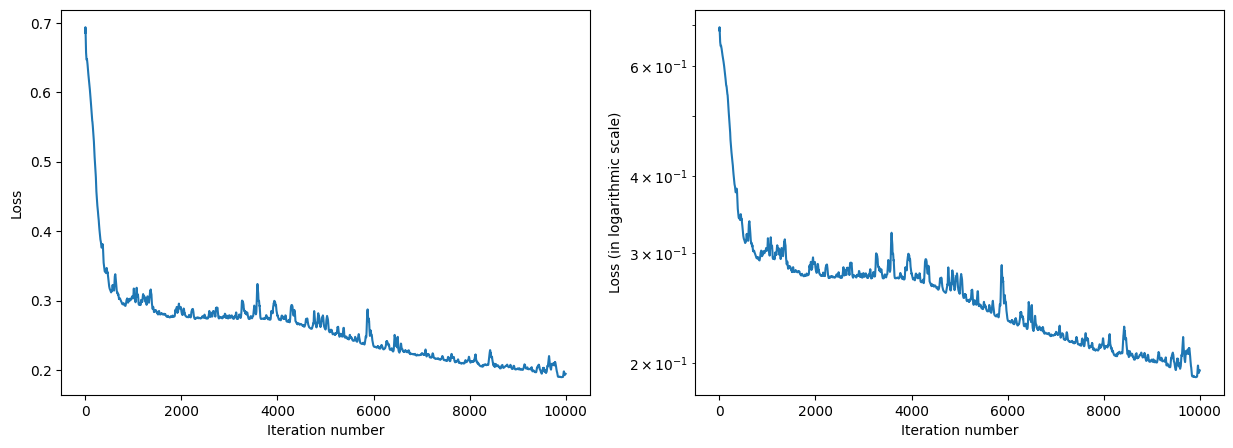

In [10]:
shallow_neural_net_sto.show_losses_over_training()

### Shallow Neural Net, with Stochastic Mini-Batch Gradient Descent 

Stochastic mini-batch gradient descent is an optimization algorithm used to train machine learning models, particularly neural networks. It is a variant of gradient descent that combines the benefits of both batch gradient descent and stochastic gradient descent.

In mini-batch gradient descent, the algorithm uses a small, fixed-sized subset of the training data (called a mini-batch) to compute the gradients at each iteration.

This means that the gradients are calculated using the average of the gradients of a small number of training examples, rather than the average of the gradients of all the training examples in the dataset as in batch gradient descent, or the gradients of a single training example as in stochastic gradient descent.

The model's weights and biases are then updated using these gradients, and the process is repeated for each mini-batch in the dataset until the model converges to a good solution.

One of the main advantages of mini-batch gradient descent is that it can be faster and more efficient than both batch gradient descent and stochastic gradient descent for large datasets.

It can also be more resistant to noise and oscillation than stochastic gradient descent, as the gradients are calculated using the average of a small number of training examples rather than a single example.

However, it may require more fine-tuning of the learning rate and other hyperparameters to achieve good results.

We implement it in the **ShallowNeuralNet_StochasticMiniBatch** class below. Pay attention to the following lines in the **train()** method. You will see that on each iteration, we randomly draw **batch_size** samples. These are then used in the **backward()** method.

```
# Get number of samples
M = inputs.shape[0]
          
# Define RNG for stochastic minibatches
rng = default_rng()

# Repeat iterations
for iteration_number in range(1, N_max + 1):

    # Select a subset of inputs and outputs with given batch size
    shuffler = rng.choice(M, size = batch_size, replace = False)
    inputs_sub = inputs[shuffler, :]
    outputs_sub = outputs[shuffler, :]

    # Backpropagate
    G_list, loss = self.backward(inputs_sub, outputs_sub, G_list, iteration_number, alpha, beta1, beta2)
```

Note that the **batch_size** is another hyperparameter, on which the **"No free lunch theorem"** applies. In general its value is set to a power of two between 16 and 256, i.e. 16, 32, 64, 128 or 256. Feel free to try different values and compared the computation times and convergence speed of this algorithm.

In [11]:
class ShallowNeuralNet_StochasticMiniBatch():
    
    def __init__(self, n_x, n_h, n_y):
        # Network dimensions
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        # Initialize parameters
        self.init_parameters_normal()
        # Loss, initialized as infinity before first calculation is made
        self.loss = float("Inf")
         
    def init_parameters_normal(self):
        # Weights and biases matrices (randomly initialized)
        self.W1 = np.random.randn(self.n_x, self.n_h)*0.1
        self.b1 = np.random.randn(1, self.n_h)*0.1
        self.W2 = np.random.randn(self.n_h, self.n_y)*0.1
        self.b2 = np.random.randn(1, self.n_y)*0.1

    def sigmoid(self, val):
        return 1/(1 + np.exp(-val))
    
    def forward(self, inputs):
        # Wx + b operation for the first layer
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        # Wx + b operation for the second layer
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        y_pred = self.sigmoid(Z2_b)
        return y_pred
    
    def CE_loss(self, inputs, outputs):
        # MSE loss function as before
        outputs_re = outputs.reshape(-1, 1)
        pred = self.forward(inputs)
        eps = 1e-10
        losses = outputs*np.log(pred + eps) + (1 - outputs)*np.log(1 - pred + eps)
        loss = -np.sum(losses)/outputs.shape[0]
        return loss
    
    def backward(self, inputs, outputs, G_list, iteration_number, alpha = 1e-5, beta1 = 0.9, beta2 = 0.999):
        # Get the number of samples in dataset
        m = inputs.shape[0]
        
        # Forward propagate
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        y_pred = self.sigmoid(Z2_b)
    
        # Compute error term
        epsilon = y_pred - outputs
        gradient_output = epsilon*y_pred*(1 - y_pred)
        error_hidden = np.dot(gradient_output, self.W2.T)
        gradient_hidden = error_hidden*A1*(1 - A1)
        
        # Compute gradients
        grad_W2 = -(1/m)*np.dot(A1.T, gradient_output)
        grad_W1 = -(1/m)*np.dot(inputs.T, gradient_hidden)
        grad_b2 = -(1/m)*np.sum(gradient_output, axis = 0, keepdims = True)
        grad_b1 = -(1/m)*np.sum(gradient_hidden, axis = 0, keepdims = True)
        
        # Momentum and gradient decay/normalization for each parameter
        V_W2, V_W1, V_b2, V_b1, S_W2, S_W1, S_b2, S_b1 = G_list
        V_W2 = beta1*V_W2 + (1 - beta1)*grad_W2
        V_W1 = beta1*V_W1 + (1 - beta1)*grad_W1
        V_b2 = beta1*V_b2 + (1 - beta1)*grad_b2
        V_b1 = beta1*V_b1 + (1 - beta1)*grad_b1
        V_W2_norm = V_W2/(1 - beta1**iteration_number)
        V_W1_norm = V_W1/(1 - beta1**iteration_number)
        V_b2_norm = V_b2/(1 - beta1**iteration_number)
        V_b1_norm = V_b1/(1 - beta1**iteration_number)
        S_W2 = beta2*S_W2 + (1 - beta2)*grad_W2**2
        S_W1 = beta2*S_W1 + (1 - beta2)*grad_W1**2
        S_b2 = beta2*S_b2 + (1 - beta2)*grad_b2**2
        S_b1 = beta2*S_b1 + (1 - beta2)*grad_b1**2
        S_W2_norm = S_W2/(1 - beta2**iteration_number)
        S_W1_norm = S_W1/(1 - beta2**iteration_number)
        S_b2_norm = S_b2/(1 - beta2**iteration_number)
        S_b1_norm = S_b1/(1 - beta2**iteration_number)
        G_list = [V_W2, V_W1, V_b2, V_b1, S_W2, S_W1, S_b2, S_b1]
        
        # Gradient descent update rules
        eps = 1e-6
        self.W2 += alpha*V_W2_norm/(np.sqrt(S_W2_norm) + eps)
        self.W1 += alpha*V_W1_norm/(np.sqrt(S_W1_norm) + eps)
        self.b2 += alpha*V_b2_norm/(np.sqrt(S_b2_norm) + eps)
        self.b1 += alpha*V_b1_norm/(np.sqrt(S_b1_norm) + eps)
        
        # Update loss
        loss = self.CE_loss(inputs, outputs)
        return G_list, loss
    
    def train(self, inputs, outputs, N_max = 1000, alpha = 1e-5, beta1 = 0.9, beta2 = 0.999, \
              delta = 1e-5, batch_size = 100, display = True):
        # Get number of samples
        M = inputs.shape[0]
        # List of losses, starts with the current loss
        self.losses_list = [self.CE_loss(inputs, outputs)]
        # Initialize G_list
        G_list = [0*self.W2, 0*self.W1, 0*self.b2, 0*self.b1, \
                  0*self.W2, 0*self.W1, 0*self.b2, 0*self.b1]
        # Define RNG for stochastic minibatches
        rng = default_rng()
        # Repeat iterations
        for iteration_number in range(1, N_max + 1):
            # Select a subset of inputs and outputs with given batch size
            shuffler = rng.choice(M, size = batch_size, replace = False)
            inputs_sub = inputs[shuffler, :]
            outputs_sub = outputs[shuffler, :]
            
            # Backpropagate
            G_list, loss = self.backward(inputs_sub, outputs_sub, G_list, iteration_number, alpha, beta1, beta2)
                
            # Update loss attribute on all losses
            self.loss = self.CE_loss(inputs, outputs)
            # Update losses list
            self.losses_list.append(self.loss)
            
            # Display
            if(display and iteration_number % (N_max*0.05) == 1):
                print("Iteration {} - Loss = {}".format(iteration_number, self.loss))
            # Check for delta value and early stop criterion
            difference = abs(self.losses_list[-1] - self.losses_list[-2])
            if(difference < delta):
                if(display):
                    message = "Stopping early - loss evolution was less than delta on"
                    message += "iteration {}.".format(iteration_number)
                    print(message)
                    break
        else:
            # Else on for loop will execute if break did not trigger
            if(display):
                print("Stopping - Maximal number of iterations reached.")
    
    def show_losses_over_training(self):
        # Initialize matplotlib
        fig, axs = plt.subplots(1, 2, figsize = (15, 5))
        axs[0].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[0].set_xlabel("Iteration number")
        axs[0].set_ylabel("Loss")
        axs[1].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[1].set_xlabel("Iteration number")
        axs[1].set_ylabel("Loss (in logarithmic scale)")
        axs[1].set_yscale("log")
        # Display
        plt.show()

As before, it is able to train just fine, despite a few "oscillations" towards convergence.

We also time it for later.

In [12]:
# Define and train neural network structure (stochastic minibatch GD)
n_x = 2
n_h = 10
n_y = 1
np.random.seed(37)
shallow_neural_net_stominibatch = ShallowNeuralNet_StochasticMiniBatch(n_x, n_h, n_y)
# Train and show final loss (and time it)
start = time()
shallow_neural_net_stominibatch.train(inputs, outputs, N_max = 10000, alpha = 1e-1, beta1 = 0.9, \
                               beta2 = 0.999, delta = 1e-10, batch_size = 50, display = True)
end = time()
time_stominibatch = end - start
print(shallow_neural_net_stominibatch.loss)

Iteration 1 - Loss = 0.6561810458269688
Iteration 501 - Loss = 0.10480300222818756
Iteration 1001 - Loss = 0.05986863280510421
Iteration 1501 - Loss = 0.03787239838229549
Iteration 2001 - Loss = 0.0272232596355599
Iteration 2501 - Loss = 0.028182804128575118
Iteration 3001 - Loss = 0.02397496736487859
Iteration 3501 - Loss = 0.0213000584833595
Iteration 4001 - Loss = 0.025573741785028834
Iteration 4501 - Loss = 0.015487927763839537
Iteration 5001 - Loss = 0.013287277007578608
Iteration 5501 - Loss = 0.013527690552274265
Iteration 6001 - Loss = 0.012811679283799948
Iteration 6501 - Loss = 0.015298461994553989
Iteration 7001 - Loss = 0.01662472153526343
Iteration 7501 - Loss = 0.018318661610685176
Iteration 8001 - Loss = 0.01082223732654083
Iteration 8501 - Loss = 0.011338685269488771
Iteration 9001 - Loss = 0.02239049951589732
Iteration 9501 - Loss = 0.01203714761970258
Stopping - Maximal number of iterations reached.
0.009094386697738422


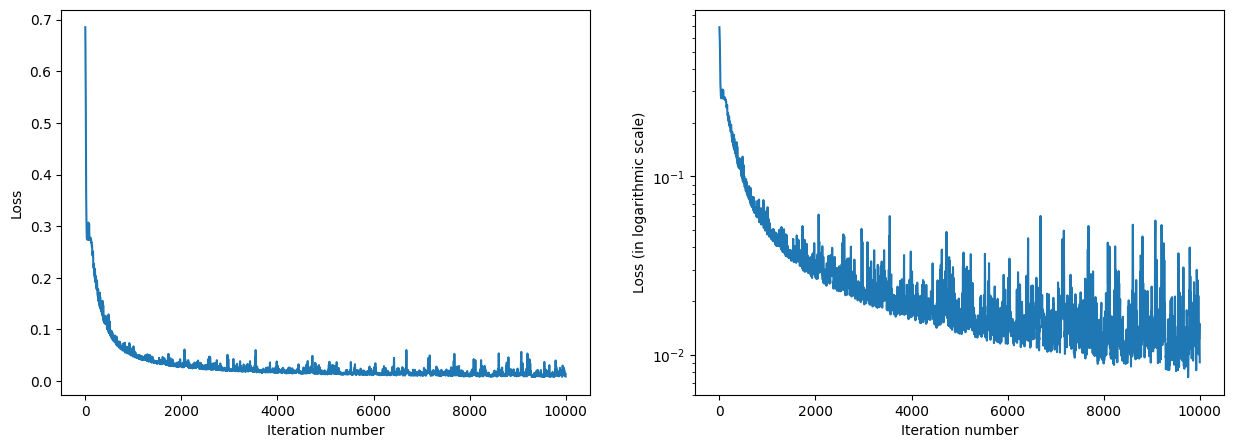

In [13]:
shallow_neural_net_stominibatch.show_losses_over_training()

### Final visualizations and discussion

As before, we might compare the training curves for all three possible implementations. We observe that the batch and stochastic minibatch gradient descent methods have roughly the same curves. The stochastic GD needed a few more iterations and has not yet converged.

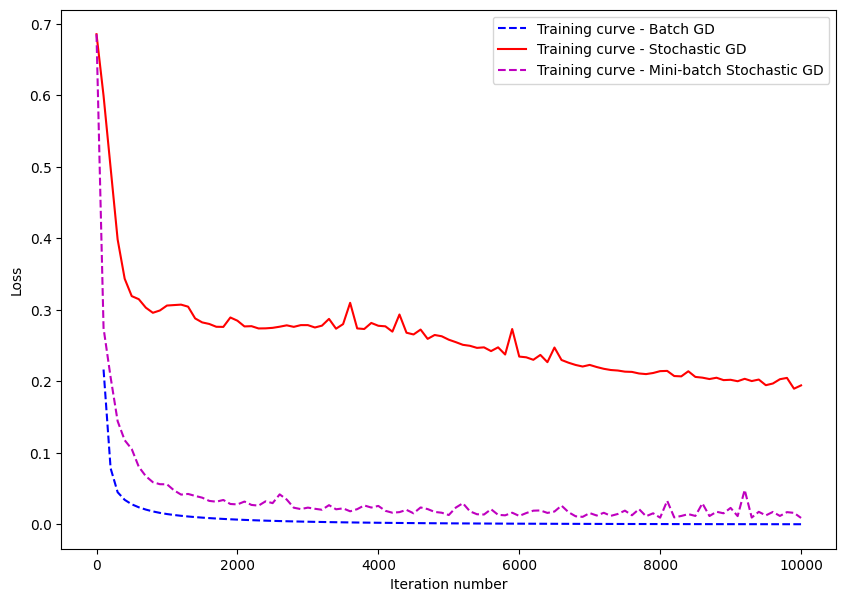

In [14]:
# Compare training curves
fig = plt.figure(figsize = (10, 7))
plt.plot(list(range(0, len(shallow_neural_net_batch.losses_list), 100)), \
         shallow_neural_net_batch.losses_list[::100], "b--", label = "Training curve - Batch GD")
plt.plot(list(range(0, len(shallow_neural_net_sto.losses_list), 100)), \
         shallow_neural_net_sto.losses_list[::100], "r", label = "Training curve - Stochastic GD ")
plt.plot(list(range(0, len(shallow_neural_net_stominibatch.losses_list), 100)), \
         shallow_neural_net_stominibatch.losses_list[::100], "m--", label = "Training curve - Mini-batch Stochastic GD")
plt.xlabel("Iteration number")
plt.ylabel("Loss")
plt.legend(loc = "best")
plt.show()

The key difference, however, has to do with training times. The Stochastic Mini-batch is somewhat faster than the batch GD. This difference will appear even more obvious when we will start playing with large datasets, that have much more than 1000 samples.

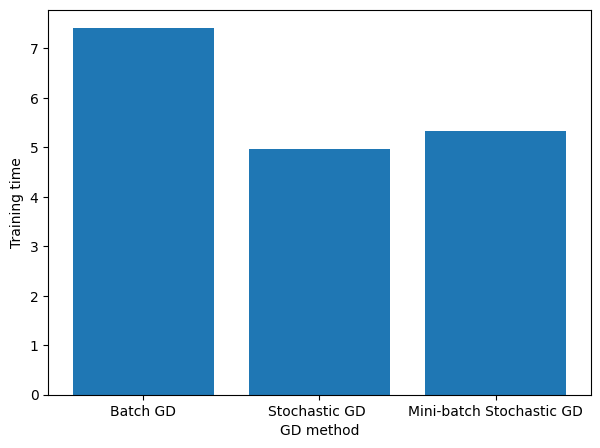

In [15]:
# Compare training curves
fig = plt.figure(figsize = (7, 5))
labels = ["Batch GD", "Stochastic GD ", "Mini-batch Stochastic GD"]
plt.bar(x = [0, 1, 2], height = [time_batch, time_sto, time_stominibatch], \
        tick_label = labels)
plt.xlabel("GD method")
plt.ylabel("Training time")
plt.show()

As before, we may confirm that the models are correctly fitting the data by plotting their boundaries. The stochastic GD model was not able to train properly (as shown in the training curves earlier), which is why it underfits the data.

In [16]:
def find_v2(v1, model, min_val, max_val, thr = 1e-3):
    # Dichotomic search, to be used for boundary drawing later
    v2_min = min_val
    v2_max = max_val
    while((v2_max - v2_min) > thr):
        v2_avg = (v2_max + v2_min)/2
        out = model.forward([v1, v2_avg])
        if(out > 0.5):
            v2_max = v2_avg
        else:
            v2_min = v2_avg
    return (v2_max + v2_min)/2

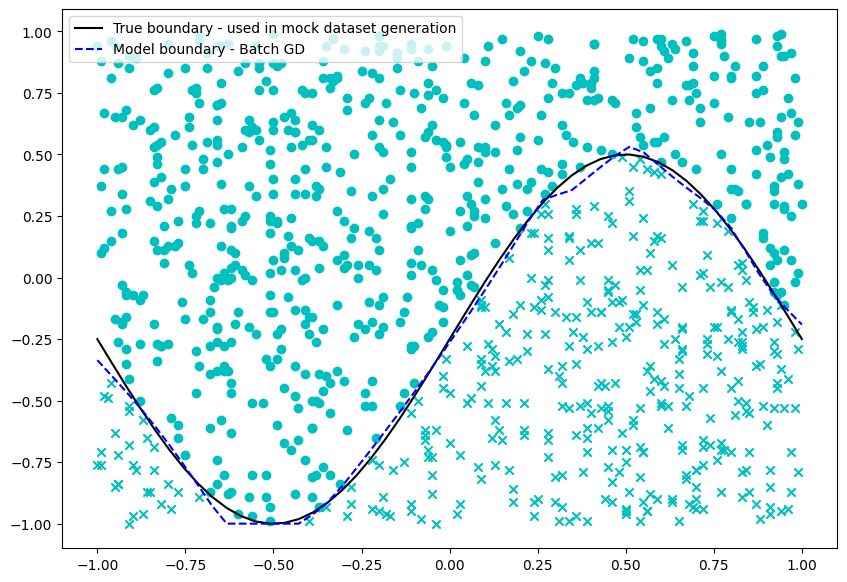

In [17]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# Scatter plot
markers = {0: "x", 1: "o"}
colors = {0: "c", 1: "c"}
indexes_0 = np.where(outputs == 0)[0]
v1_0 = val1_list[indexes_0]
v2_0 = val2_list[indexes_0]
indexes_1 = np.where(outputs == 1)[0]
v1_1 = val1_list[indexes_1]
v2_1 = val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])

# Display true boundary
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_true = [-1/4 + 3/4*np.sin(v1*np.pi) for v1 in x1]
plt.plot(x1, x2_true, "k", label = "True boundary - Used in mock dataset generation")

# Display model boundary (sigmoid model, vanilla GD)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_batch = [find_v2(v1, shallow_neural_net_batch, min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_batch, "b--", label = "Model boundary - Batch GD")

# Show
plt.legend(loc = "best")
plt.show()

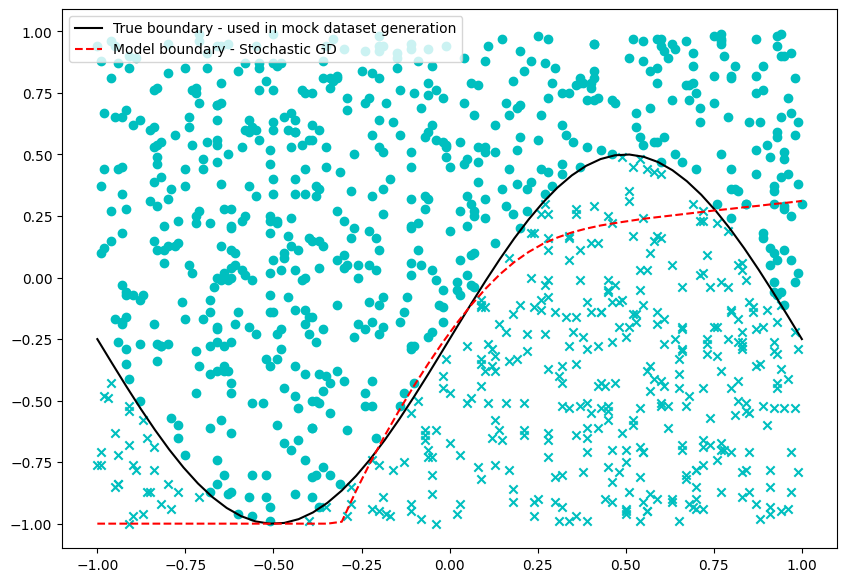

In [18]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# Scatter plot
markers = {0: "x", 1: "o"}
colors = {0: "c", 1: "c"}
indexes_0 = np.where(outputs == 0)[0]
v1_0 = val1_list[indexes_0]
v2_0 = val2_list[indexes_0]
indexes_1 = np.where(outputs == 1)[0]
v1_1 = val1_list[indexes_1]
v2_1 = val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])

# Display true boundary
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_true = [-1/4 + 3/4*np.sin(v1*np.pi) for v1 in x1]
plt.plot(x1, x2_true, "k", label = "True boundary - Used in mock dataset generation")

# Display model boundary (sigmoid model, Adagrad GD)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_sto = [find_v2(v1, shallow_neural_net_sto, min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_sto, "r--", label = "Model boundary - Stochastic GD")

# Show
plt.legend(loc = "best")
plt.show()

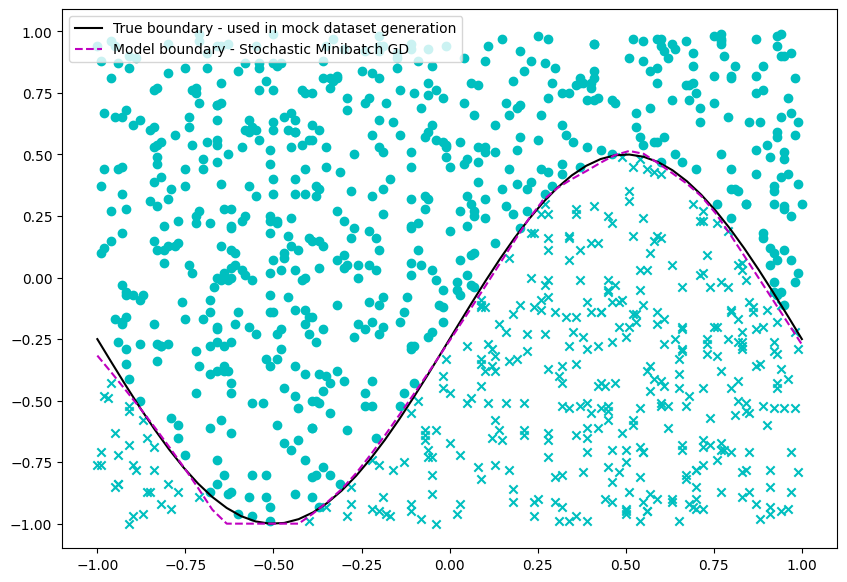

In [19]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# Scatter plot
markers = {0: "x", 1: "o"}
colors = {0: "c", 1: "c"}
indexes_0 = np.where(outputs == 0)[0]
v1_0 = val1_list[indexes_0]
v2_0 = val2_list[indexes_0]
indexes_1 = np.where(outputs == 1)[0]
v1_1 = val1_list[indexes_1]
v2_1 = val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])

# Display true boundary
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_true = [-1/4 + 3/4*np.sin(v1*np.pi) for v1 in x1]
plt.plot(x1, x2_true, "k", label = "True boundary - Used in mock dataset generation")

# Display model boundary (sigmoid model, Adam GD)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_stominibatch = [find_v2(v1, shallow_neural_net_stominibatch, min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_stominibatch, "m--", label = "Model boundary - Stochastic Minibatch GD")

# Show
plt.legend(loc = "best")
plt.show()

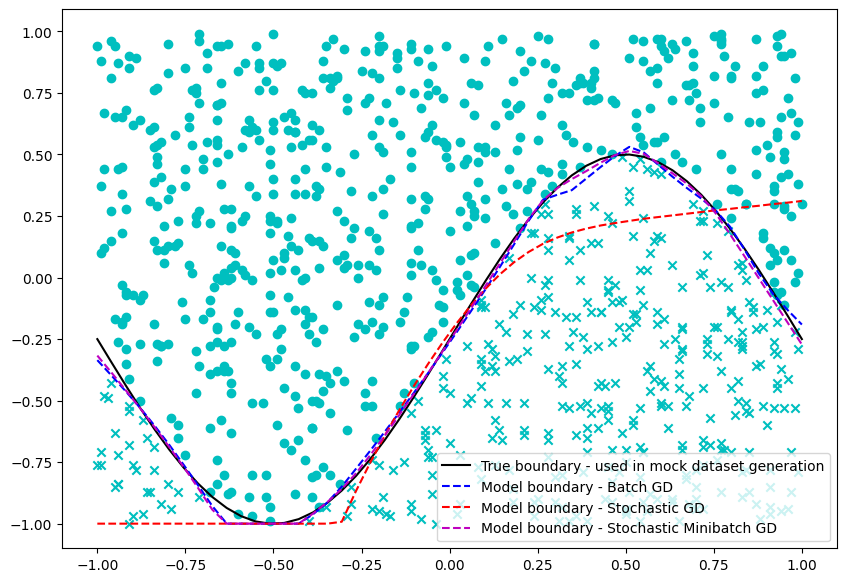

In [20]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# Scatter plot
markers = {0: "x", 1: "o"}
colors = {0: "c", 1: "c"}
indexes_0 = np.where(outputs == 0)[0]
v1_0 = val1_list[indexes_0]
v2_0 = val2_list[indexes_0]
indexes_1 = np.where(outputs == 1)[0]
v1_1 = val1_list[indexes_1]
v2_1 = val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])

# Display true boundary
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_true = [-1/4 + 3/4*np.sin(v1*np.pi) for v1 in x1]
plt.plot(x1, x2_true, "k", label = "True boundary - Used in mock dataset generation")

# Display model boundary (sigmoid model, vanilla GD)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_batch = [find_v2(v1, shallow_neural_net_batch, min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_batch, "b--", label = "Model boundary - Batch GD")

# Display model boundary (sigmoid model, Adagrad GD)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_sto = [find_v2(v1, shallow_neural_net_sto, min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_sto, "r--", label = "Model boundary - Stochastic GD")

# Display model boundary (sigmoid model, Adam GD)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_stominibatch = [find_v2(v1, shallow_neural_net_stominibatch, min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_stominibatch, "m--", label = "Model boundary - Stochastic Minibatch GD")

# Show
plt.legend(loc = "best")
plt.show()

### What's next?

In the next notebook, we will investigate some additional variations on these optimizers, namely the early stopping and learning rate decays.